# Modelo de deep learning baseado na memória de curto prazo (LSTM)

## Bibliotecas

In [152]:
# Estamos usando a versão 3.10.11 do python

# pip install pandas tensorflow matplotlib scikit-learn pandas_datareader

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from pathlib import Path
import os
pd.options.mode.chained_assignment = None

## Tratmento das bases

In [153]:
# Diretório onde o script está localizado
base_diretório = Path(os.getcwd())
base_diretório = base_diretório.parent
caminho = base_diretório / 'Bases' / 'BNB Historical Data.csv'

# Ler arquivo da base
acao = pd.read_csv(caminho)

# Formatar data
acao['Date'] = pd.to_datetime(acao['Date'], format='%m/%d/%Y')


# Ler o arquivo ano.txt e pegar o ano
# with open('ano.txt', 'r') as file:
#     ano = int(file.read().strip()) 

# Filtrar a data em que vamos puxar os dados
# acao = acao[acao['Date'].dt.year >= ano]

# Converter as colunas referentes a dinheiro para float
colunas_dinheiro = ['Price', 'Open', 'High', 'Low']
for coluna in colunas_dinheiro:
    if acao[coluna].dtype == 'object':  
        acao[coluna] = pd.to_numeric(acao[coluna].str.replace(',', ''))

# Converter a coluna 'Change %' para float
if acao['Change %'].dtype == 'object':  
    acao['Change %'] = pd.to_numeric(acao['Change %'].str.replace('%', ''))

def converter_vol_para_numero(valor):
    if isinstance(valor, str):  # Verifica se o valor é uma string
        if 'K' in valor:
            return float(valor.replace('K', '').replace(',', '')) * 1000
        elif 'M' in valor:
            return float(valor.replace('M', '').replace(',', '')) * 1000000
        elif 'B' in valor:
            return float(valor.replace('B', '').replace(',', '')) * 1000000000
        else:
            return float(valor.replace(',', ''))
    else:
        return valor  # Retorna o valor diretamente se já for numérico

# Aplicar a função na coluna 'Vol.'
acao['Vol.'] = acao['Vol.'].apply(converter_vol_para_numero)

# Ordenar data das bases
acao = acao.sort_values(by='Date', ascending=True)

acao = acao.rename(columns={'Vol.': 'Volume'})

acao

,Date,Price,Open,High,Low,Volume,Change %
0,2017-11-09,1.99,1.99,2.20,1.90,283350.0,0.00
1,2017-11-10,1.71,1.99,2.02,1.60,483230.0,-14.07
2,2017-11-11,1.66,1.71,1.93,1.58,256710.0,-2.92
3,2017-11-12,1.49,1.66,1.70,1.34,456480.0,-10.24
4,2017-11-13,1.68,1.49,1.74,1.49,166010.0,12.75
...,...,...,...,...,...,...,...
2483,2024-08-27,533.68,548.30,558.25,522.86,322040.0,-2.67
2484,2024-08-28,536.60,533.21,546.64,523.02,295430.0,0.55
2485,2024-08-29,536.51,536.61,545.38,531.79,177620.0,-0.02
2486,2024-08-30,535.21,536.51,543.19,522.65,210690.0,-0.24


In [154]:
# Diretório base onde os arquivos CSV estão localizados
base_diretorio = Path(os.getcwd()).parent
bases_diretorio = base_diretorio / 'Bases'

# Definir os caminhos para cada criptomoeda
arquivos = {
    'Bitcoin': bases_diretorio / 'Bitcoin Historical Data.csv',
    'Ethereum': bases_diretorio / 'Ethereum Historical Data.csv',
    'BNB': bases_diretorio / 'BNB Historical Data.csv',
    'Solana': bases_diretorio / 'Solana Historical Data.csv'
}

# Função para tratar os dados de cada criptomoeda
def tratar_dados_cripto(caminho_csv):
    # Ler o arquivo CSV
    acao = pd.read_csv(caminho_csv)

    # Formatar a coluna de data
    acao['Date'] = pd.to_datetime(acao['Date'], format='%m/%d/%Y')

    # Ler o arquivo ano.txt e pegar o ano
    # with open('ano.txt', 'r') as file:
    #     ano = int(file.read().strip()) 

    # Filtrar a data em que vamos puxar os dados
    # acao = acao[acao['Date'].dt.year >= ano]

    # Converter as colunas de dinheiro para float
    colunas_dinheiro = ['Price', 'Open', 'High', 'Low']
    for coluna in colunas_dinheiro:
        if acao[coluna].dtype == 'object':  
            acao[coluna] = pd.to_numeric(acao[coluna].str.replace(',', ''))

    # Converter a coluna 'Change %' para float
    if acao['Change %'].dtype == 'object':  
        acao['Change %'] = pd.to_numeric(acao['Change %'].str.replace('%', ''))

    # Função para converter o volume (coluna 'Vol.') para número
    def converter_vol_para_numero(valor):
        if isinstance(valor, str):  # Verifica se o valor é uma string
            if 'K' in valor:
                return float(valor.replace('K', '').replace(',', '')) * 1000
            elif 'M' in valor:
                return float(valor.replace('M', '').replace(',', '')) * 1000000
            elif 'B' in valor:
                return float(valor.replace('B', '').replace(',', '')) * 1000000000
            else:
                return float(valor.replace(',', ''))
        else:
            return valor  # Retorna o valor diretamente se já for numérico

    # Aplicar a função na coluna 'Vol.'
    acao['Vol.'] = acao['Vol.'].apply(converter_vol_para_numero)

    # Ordenar os dados pela data
    acao = acao.sort_values(by='Date', ascending=True)

    # Renomear a coluna 'Vol.' para 'Volume'
    acao = acao.rename(columns={'Vol.': 'Volume'})

    return acao

# Aplicar a função para cada criptomoeda e armazenar o resultado em um DataFrame
df_bitcoin = tratar_dados_cripto(arquivos['Bitcoin'])
df_ethereum = tratar_dados_cripto(arquivos['Ethereum'])
df_bnb = tratar_dados_cripto(arquivos['BNB'])
df_solana = tratar_dados_cripto(arquivos['Solana'])


## Aplicando modelo de ML

In [155]:
#nao pode ser ajustados

cotacao = acao['Price'].to_numpy().reshape(-1, 1)

cotacao

array([[  1.99],
       [  1.71],
       [  1.66],
       ...,
       [536.51],
       [535.21],
       [532.9 ]])

In [156]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

1990

In [157]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[7.40663931e-04],
       [3.25892130e-04],
       [2.51825737e-04],
       ...,
       [7.92540033e-01],
       [7.90614307e-01],
       [7.87192439e-01]])

In [158]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []


for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([7.40663931e-04, 3.25892130e-04, 2.51825737e-04, 0.00000000e+00,
       2.81452294e-04, 1.48132786e-04, 8.88796717e-05, 1.03692950e-04,
       1.48132786e-05, 2.66639015e-04, 1.62946065e-04, 2.22199179e-04,
       1.48132786e-04, 1.92572622e-04, 1.18506229e-04, 3.55518687e-04,
       5.62904588e-04, 5.18464752e-04, 6.81410817e-04, 6.36970981e-04,
       3.99958523e-04, 6.81410817e-04, 8.29543603e-04, 8.73983439e-04,
       1.14062245e-03, 1.57020753e-03, 1.65908721e-03, 1.51095442e-03,
       1.73315360e-03, 1.92572622e-03, 1.71834032e-03, 1.43688803e-03,
       1.77759343e-03, 1.57020753e-03, 1.82203327e-03, 2.45900425e-03,
       3.89589228e-03, 4.66618277e-03, 6.68078866e-03, 6.68078866e-03,
       6.23639030e-03, 5.42165998e-03, 5.43647325e-03, 4.14771801e-03,
       4.31066408e-03, 5.46609981e-03, 7.36219948e-03, 1.14951042e-02,
       1.27097931e-02, 1.14951042e-02, 1.06951872e-02, 9.03609996e-03,
       1.04285482e-02, 1.03100419e-02, 1.07100004e-02, 1.15691706e-02,
     

In [159]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

print(treinamento_x)

[[7.40663931e-04 3.25892130e-04 2.51825737e-04 ... 1.98349801e-02
  3.12708312e-02 2.53307064e-02]
 [3.25892130e-04 2.51825737e-04 0.00000000e+00 ... 3.12708312e-02
  2.53307064e-02 2.44567230e-02]
 [2.51825737e-04 0.00000000e+00 2.81452294e-04 ... 2.53307064e-02
  2.44567230e-02 2.35679263e-02]
 ...
 [4.66633090e-01 4.60248567e-01 4.65003629e-01 ... 5.12850519e-01
  5.01444295e-01 5.05888278e-01]
 [4.60248567e-01 4.65003629e-01 4.59226451e-01 ... 5.01444295e-01
  5.05888278e-01 4.75372924e-01]
 [4.65003629e-01 4.59226451e-01 4.61004044e-01 ... 5.05888278e-01
  4.75372924e-01 4.68988401e-01]]
[[[7.40663931e-04]
  [3.25892130e-04]
  [2.51825737e-04]
  ...
  [1.98349801e-02]
  [3.12708312e-02]
  [2.53307064e-02]]

 [[3.25892130e-04]
  [2.51825737e-04]
  [0.00000000e+00]
  ...
  [3.12708312e-02]
  [2.53307064e-02]
  [2.44567230e-02]]

 [[2.51825737e-04]
  [0.00000000e+00]
  [2.81452294e-04]
  ...
  [2.53307064e-02]
  [2.44567230e-02]
  [2.35679263e-02]]

 ...

 [[4.66633090e-01]
  [4.6024

In [160]:
#construindo o modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

# Primeira camada LSTM com dropout
modelo.add(LSTM(100, return_sequences=True, input_shape=(treinamento_x.shape[1], 1)))

# Segunda camada LSTM
modelo.add(LSTM(50, return_sequences=False))

# Camada totalmente conectada com 25 neurônios
modelo.add(Dense(25))

# Camada final de saída com 1 neurônio
modelo.add(Dense(1))

treinamento_x.shape[1]

c:\Users\yupopic\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [161]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [162]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros.
#epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo. 

modelo.fit(treinamento_x, treinamento_y, batch_size=10, epochs=20)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0076
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0013
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0010
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 8.5699e-04
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 5.6978e-04
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 5.6505e-04
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 8.0616e-04
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.0107e-04
Epoch 9/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 6.1380e-04
Epoch 10/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 6.9304e-04
Epoch 11/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 6.5068e-04
Epoch 12/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 5.3147e-04
Epoch 13/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 4.6367e-04
Epoch 14/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 3.7535e-04

In [163]:
# Vriar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [164]:
# Reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [165]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


array([[315.72015],
       [325.62448],
       [328.1265 ],
       [327.86646],
       [332.6662 ],
       [328.29095],
       [326.25674],
       [321.1209 ],
       [318.0046 ],
       [329.46252],
       [327.37073],
       [319.80716],
       [320.42868],
       [320.03595],
       [321.95078],
       [319.2581 ],
       [317.25565],
       [311.5107 ],
       [308.47955],
       [309.65674],
       [305.51343],
       [304.6188 ],
       [306.31296],
       [308.09982],
       [309.51852],
       [308.23322],
       [309.7654 ],
       [306.90372],
       [305.3205 ],
       [306.45392],
       [303.9881 ],
       [304.92255],
       [308.8319 ],
       [304.57773],
       [301.4665 ],
       [302.4498 ],
       [303.6395 ],
       [308.96744],
       [308.97342],
       [308.09967],
       [304.22293],
       [301.4799 ],
       [302.8237 ],
       [303.2576 ],
       [302.1835 ],
       [281.31396],
       [276.2009 ],
       [261.28873],
       [257.95505],
       [257.48862],


In [166]:
# Criando o grafico do modelo
treinamento = acao.iloc[:tamanho_dados_treinamento, :]
df_previsao = pd.DataFrame({"Date": acao['Date'].iloc[tamanho_dados_treinamento:],
                        "Price": acao['Price'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


In [167]:
treinamento

,Date,Price,Open,High,Low,Volume,Change %
0,2017-11-09,1.99,1.99,2.20,1.90,283350.0,0.00
1,2017-11-10,1.71,1.99,2.02,1.60,483230.0,-14.07
2,2017-11-11,1.66,1.71,1.93,1.58,256710.0,-2.92
3,2017-11-12,1.49,1.66,1.70,1.34,456480.0,-10.24
4,2017-11-13,1.68,1.49,1.74,1.49,166010.0,12.75
...,...,...,...,...,...,...,...
1985,2023-04-17,340.00,347.70,350.00,337.71,578690.0,-2.21
1986,2023-04-18,343.00,340.00,346.48,337.20,407350.0,0.88
1987,2023-04-19,322.40,343.00,343.70,320.39,562930.0,-6.01
1988,2023-04-20,318.09,322.40,326.70,315.50,385170.0,-1.34


In [168]:
df_previsao

,Date,Price,predicoes
1990,2023-04-22,332.08,315.720154
1991,2023-04-23,330.70,325.624481
1992,2023-04-24,331.10,328.126495
1993,2023-04-25,338.39,327.866455
1994,2023-04-26,330.50,332.666199
...,...,...,...
2483,2024-08-27,533.68,537.643738
2484,2024-08-28,536.60,521.074646
2485,2024-08-29,536.51,523.442322
2486,2024-08-30,535.21,526.207031


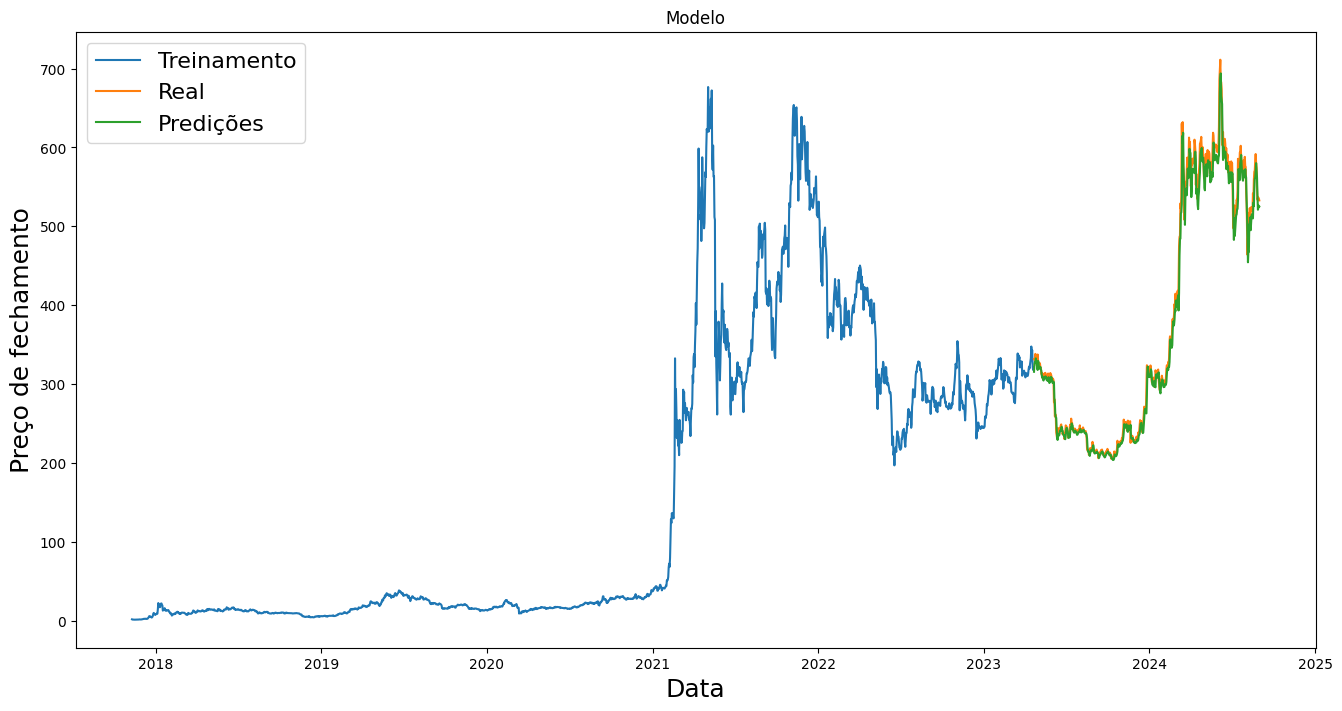

In [169]:
# Setar a data como index dos df (df_previsao e treinamento)
df_previsao.set_index('Date', inplace=True)
treinamento.set_index('Date', inplace=True)

plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento[['Price']])
plt.plot(df_previsao[['Price', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [170]:
df_previsao.sort_index()

df_previsao

,Price,predicoes
Date,,
2023-04-22,332.08,315.720154
2023-04-23,330.70,325.624481
2023-04-24,331.10,328.126495
2023-04-25,338.39,327.866455
2023-04-26,330.50,332.666199
...,...,...
2024-08-27,533.68,537.643738
2024-08-28,536.60,521.074646
2024-08-29,536.51,523.442322


In [171]:
df_previsao_semanal = df_previsao
df_previsao_semanal['Semana'] = ((df_previsao_semanal.index - df_previsao_semanal.index.min()).days // 7) + 1
df_previsao_semanal.head(30)

,Price,predicoes,Semana
Date,,,
2023-04-22,332.08,315.720154,1
2023-04-23,330.70,325.624481,1
2023-04-24,331.10,328.126495,1
2023-04-25,338.39,327.866455,1
2023-04-26,330.50,332.666199,1
2023-04-27,330.70,328.290955,1
2023-04-28,324.10,326.256744,1
2023-04-29,321.90,321.120911,2
2023-04-30,337.58,318.004608,2


In [172]:
df_previsao_semanal = df_previsao_semanal.reset_index() 
df_previsao_semanal

,Date,Price,predicoes,Semana
0,2023-04-22,332.08,315.720154,1
1,2023-04-23,330.70,325.624481,1
2,2023-04-24,331.10,328.126495,1
3,2023-04-25,338.39,327.866455,1
4,2023-04-26,330.50,332.666199,1
...,...,...,...,...
493,2024-08-27,533.68,537.643738,71
494,2024-08-28,536.60,521.074646,71
495,2024-08-29,536.51,523.442322,71
496,2024-08-30,535.21,526.207031,71


# Metricas para calcular nosso modelo de ML

### Mean Absolute Error (MAE) e Mean Absolute Percentage Error (MAPE)

In [173]:
# A média das diferenças absolutas entre as previsões e os valores reais. Penaliza todos os erros da mesma forma

mae = mean_absolute_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 9.59


In [174]:
# Calcular o MAPE
mape = mean_absolute_percentage_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f} = {100*mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.0230 = 2.30%


### Root Mean Squared Error (RMSE)

In [175]:
# A raiz quadrada da média dos erros ao quadrado. Dá mais peso a grandes erros

rmse = mean_squared_error(df_previsao['Price'], df_previsao['predicoes'], squared=False)
mean_price = df_previsao['Price'].mean()

print(f"RMSE: {rmse}")
print(f"RMSE percentual: {(rmse / mean_price)} = {(rmse / mean_price)*100:.3}%")

RMSE: 14.829876097755879
RMSE percentual: 0.03943647584732325 = 3.94%


c:\Users\yupopic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Directional Accuracy (Semanal)

In [176]:
df_previsao_semanal.reset_index() 
# Agrupar por semana e calcular o preço médio semanal para real e previsões
df_teste_semana = df_previsao_semanal.groupby('Semana').agg({
    'Price': 'mean',       # Preço real médio por semana
    'predicoes': 'mean',   # Previsão média por semana
    'Date': 'first'        # Pega a primeira data da semana 
})

# Adicionar colunas de mês e ano com base na coluna 'Data'
df_teste_semana['Mes'] = df_teste_semana['Date'].dt.month
df_teste_semana['Ano'] = df_teste_semana['Date'].dt.year

# Calcular a variação percentual semanal para Price e Predicoes
df_teste_semana['Variação Real (%)'] = df_teste_semana['Price'].pct_change() * 100
df_teste_semana['Variação Prevista (%)'] = df_teste_semana['predicoes'].pct_change() * 100


# Remover NaN (primeira linha não terá variação por não ter valor anterior)
df_teste_semana = df_teste_semana.dropna()

# Calcular se a direção do valor previsto foi igual ao real (1 = acertou | 0 = errou)
df_teste_semana['direcao_correta'] = np.where(
    (df_teste_semana['Variação Real (%)'] > 0) & (df_teste_semana['Variação Prevista (%)'] > 0) |
    (df_teste_semana['Variação Real (%)'] < 0) & (df_teste_semana['Variação Prevista (%)'] < 0),
    1, 0
)

# Calcular a métrica de Erro de Direção (Directional Accuracy)
directional_accuracy = df_teste_semana['direcao_correta'].mean()

# Exibir resultados
print(f"Directional Accuracy (Semanal): {directional_accuracy * 100:.2f}%")

df_teste_semana

Directional Accuracy (Semanal): 91.55%


,Price,predicoes,Date,Mes,Ano,Variação Real (%),Variação Prevista (%),direcao_correta
Semana,,,,,,,,
2,326.541429,322.318634,2023-04-29,4,2023,-1.371264,-1.239675,1
3,314.171429,313.375000,2023-05-06,5,2023,-3.788187,-2.774781,1
4,311.441429,307.636047,2023-05-13,5,2023,-0.868952,-1.831335,1
5,308.158571,305.080170,2023-05-20,5,2023,-1.054085,-0.830811,1
6,309.042857,305.404633,2023-05-27,5,2023,0.286958,0.106359,1
...,...,...,...,...,...,...,...,...
68,496.491429,489.752716,2024-08-03,8,2024,-13.606229,-13.637853,1
69,518.791429,507.820770,2024-08-10,8,2024,4.491518,3.689218,1
70,563.672857,543.405701,2024-08-17,8,2024,8.651151,7.007384,1


In [177]:
df_teste_semana.to_csv("previsão semanal - BNB.csv")